# Complete Causal Inference Pipeline for IHDP Dataset


This script performs:

1. Data loading and preprocessing
2. Causal graph construction (with optional discovery)
3. Multiple causal effect estimation methods
4. Heterogeneous treatment effect analysis (CATE)
5. Policy learning and optimization
6. Sensitivity analysis and refutation tests


In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# DoWhy imports
from dowhy import CausalModel
import dowhy.datasets


# EconML imports for CATE estimation
try:
    from econml.dml import CausalForestDML, LinearDML
    from econml.dr import DRLearner
    from econml.metalearners import TLearner, SLearner, XLearner
    ECONML_AVAILABLE = True
except ImportError:
    print("Warning: EconML not installed. CATE analysis will be limited.")
    print("Install with: pip install econml")
    ECONML_AVAILABLE = False

# Causal discovery (optional)
try:
    from causallearn.search.ConstraintBased.FCI import fci
    from causallearn.utils.GraphUtils import GraphUtils
    CAUSAL_LEARN_AVAILABLE = True
except ImportError:
    print("Warning: causal-learn not installed. Causal discovery disabled.")
    print("Install with: pip install causal-learn")
    CAUSAL_LEARN_AVAILABLE = False

## Loading IHDP Dataset


In [24]:
def load_ihdp_data():
    """Load and preprocess IHDP dataset."""
    print("=" * 80)
    print("LOADING IHDP DATASET")
    print("=" * 80)
    
    url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
    df = pd.read_csv(url, header=None)
    
    # Set column names
    col = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"]
    for i in range(1, 26):
        col.append(f"x{i}")
    df.columns = col
    
    # Convert treatment to boolean
    df['treatment'] = df['treatment'].astype(bool)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Treatment distribution:\n{df['treatment'].value_counts()}")
    print(f"\nOutcome statistics:")
    print(df['y_factual'].describe())
    
    # Calculate true ATE (we have counterfactuals!)
    true_ate = (df['y_factual'][df['treatment']] - df['mu0'][df['treatment']]).mean() + \
               (df['mu1'][~df['treatment']] - df['y_factual'][~df['treatment']]).mean()
    print(f"\nTrue ATE (from counterfactuals): {true_ate:.4f}")
    
    return df, true_ate

In [25]:
# ============================================================================
# 2. CAUSAL GRAPH CONSTRUCTION
# ============================================================================

def create_causal_graph(df, method='assumed'):
    """
    Create causal graph using different methods.
    
    Parameters:
    -----------
    method : str
        'assumed' - Use domain knowledge
        'discovery' - Use FCI algorithm (requires causal-learn)
    """
    print("\n" + "=" * 80)
    print("CAUSAL GRAPH CONSTRUCTION")
    print("=" * 80)
    
    confounders = [f"x{i}" for i in range(1, 26)]
    
    if method == 'assumed':
        print("Using assumed causal structure:")
        print("  Confounders → Treatment")
        print("  Confounders → Outcome")
        print("  Treatment → Outcome")
        
        # Create DoWhy causal model
        model = CausalModel(
            data=df,
            treatment='treatment',
            outcome='y_factual',
            common_causes=confounders
        )
        
        return model, confounders
    
    elif method == 'discovery' and CAUSAL_LEARN_AVAILABLE:
        print("Running FCI algorithm for causal discovery...")
        print("(This may take a few minutes)")
        
        # Prepare data for FCI
        data_matrix = df[confounders + ['treatment', 'y_factual']].values
        
        # Run FCI
        G, edges = fci(data_matrix, alpha=0.05, verbose=False)
        
        print("Causal discovery complete!")
        print(f"Discovered {len(edges)} edges")
        
        # For simplicity, still use assumed structure
        # In practice, you'd parse the discovered graph
        model = CausalModel(
            data=df,
            treatment='treatment',
            outcome='y_factual',
            common_causes=confounders
        )
        
        return model, confounders
    
    else:
        print("Using assumed structure (discovery not available)")
        model = CausalModel(
            data=df,
            treatment='treatment',
            outcome='y_factual',
            common_causes=confounders
        )
        return model, confounders



In [26]:

# ============================================================================
# 3. CAUSAL EFFECT ESTIMATION
# ============================================================================

def estimate_causal_effects(model, df, true_ate):
    """Estimate causal effects using multiple methods."""
    print("\n" + "=" * 80)
    print("CAUSAL EFFECT ESTIMATION")
    print("=" * 80)
    
    # Identify the causal effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    results = {}
    methods = [
        ("Linear Regression", "backdoor.linear_regression"),
        ("Propensity Score Matching", "backdoor.propensity_score_matching"),
        ("Propensity Score Weighting", "backdoor.propensity_score_weighting"),
        ("Propensity Score Stratification", "backdoor.propensity_score_stratification"),
    ]
    
    print("\nEstimating Average Treatment Effect (ATE):\n")
    print(f"{'Method':<35} {'Estimate':>10} {'Bias':>10} {'% Error':>10}")
    print("-" * 70)
    
    for name, method in methods:
        try:
            estimate = model.estimate_effect(
                identified_estimand,
                method_name=method,
                test_significance=True
            )
            ate = estimate.value
            bias = ate - true_ate
            pct_error = (bias / true_ate) * 100
            
            results[name] = {
                'estimate': ate,
                'bias': bias,
                'pct_error': pct_error
            }
            
            print(f"{name:<35} {ate:>10.4f} {bias:>10.4f} {pct_error:>9.2f}%")
            
        except Exception as e:
            print(f"{name:<35} {'ERROR':>10}")
            results[name] = {'estimate': np.nan, 'bias': np.nan, 'pct_error': np.nan}
    
    print(f"\n{'True ATE':<35} {true_ate:>10.4f}")
    
    return results, identified_estimand



In [27]:
def estimate_cate(df, confounders):
    """Estimate Conditional Average Treatment Effects."""
    print("\n" + "=" * 80)
    print("HETEROGENEOUS TREATMENT EFFECTS (CATE)")
    print("=" * 80)
    
    if not ECONML_AVAILABLE:
        print("EconML not available. Skipping CATE estimation.")
        return None
    
    # Prepare data
    X = df[confounders].values
    T = df['treatment'].values.astype(int)
    Y = df['y_factual'].values
    
    # Split data
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
        X, T, Y, test_size=0.3, random_state=42
    )
    
    print("\nFitting CATE models...")
    
    cate_models = {}
    
    # 1. Causal Forest (DML) - for binary treatment
    print("  - Causal Forest DML...")
    try:
        cf_model = CausalForestDML(
            model_y=GradientBoostingRegressor(random_state=42),
            model_t=GradientBoostingRegressor(random_state=42),  # Use regressor for propensity
            discrete_treatment=True,  # Specify binary treatment
            random_state=42
        )
        cf_model.fit(Y_train, T_train, X=X_train, W=None)
        cate_cf = cf_model.effect(X_test)
        cate_models['Causal Forest'] = cate_cf
    except Exception as e:
        print(f"    Error: {e}")
    
    # 2. Linear DML - for binary treatment
    print("  - Linear DML...")
    try:
        linear_dml = LinearDML(
            model_y=GradientBoostingRegressor(random_state=42),
            model_t=GradientBoostingRegressor(random_state=42),  # Use regressor for propensity
            discrete_treatment=True,  # Specify binary treatment
            random_state=42
        )
        linear_dml.fit(Y_train, T_train, X=X_train, W=None)
        cate_linear = linear_dml.effect(X_test)
        cate_models['Linear DML'] = cate_linear
    except Exception as e:
        print(f"    Error: {e}")
    
    # 3. T-Learner
    print("  - T-Learner...")
    try:
        t_learner = TLearner(
            models=GradientBoostingRegressor(random_state=42)
        )
        t_learner.fit(Y_train, T_train, X=X_train)
        cate_t = t_learner.effect(X_test)
        cate_models['T-Learner'] = cate_t
    except Exception as e:
        print(f"    Error: {e}")
    
    # 4. X-Learner
    print("  - X-Learner...")
    try:
        x_learner = XLearner(
            models=GradientBoostingRegressor(random_state=42),
            propensity_model=LogisticRegression()
        )
        x_learner.fit(Y_train, T_train, X=X_train)
        cate_x = x_learner.effect(X_test)
        cate_models['X-Learner'] = cate_x
    except Exception as e:
        print(f"    Error: {e}")
    
    # Summarize CATE estimates
    print("\nCATE Summary Statistics:")
    print(f"{'Model':<20} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    print("-" * 60)
    
    for name, cate in cate_models.items():
        print(f"{name:<20} {np.mean(cate):>10.4f} {np.std(cate):>10.4f} "
              f"{np.min(cate):>10.4f} {np.max(cate):>10.4f}")
    
    # Visualize CATE distribution
    if len(cate_models) > 0:
        plot_cate_distribution(cate_models)
    
    return cate_models


def plot_cate_distribution(cate_models):
    """Plot distribution of CATE estimates."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, (name, cate) in enumerate(cate_models.items()):
        if idx < 4:
            axes[idx].hist(cate, bins=50, alpha=0.7, edgecolor='black')
            axes[idx].axvline(np.mean(cate), color='red', linestyle='--', 
                            label=f'Mean: {np.mean(cate):.2f}')
            axes[idx].set_title(f'{name}')
            axes[idx].set_xlabel('Treatment Effect')
            axes[idx].set_ylabel('Frequency')
            axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig('cate_distribution.png', dpi=300, bbox_inches='tight')
    print("\nCATE distribution plot saved as 'cate_distribution.png'")



In [28]:
# ============================================================================
# 5. POLICY LEARNING
# ============================================================================

def policy_learning(df, cate_models, confounders):
    """Learn optimal treatment assignment policy."""
    print("\n" + "=" * 80)
    print("POLICY LEARNING")
    print("=" * 80)
    
    if not cate_models or not ECONML_AVAILABLE:
        print("CATE models not available. Skipping policy learning.")
        return
    
    # Use the best CATE model (e.g., Causal Forest)
    if 'Causal Forest' in cate_models:
        cate = cate_models['Causal Forest']
    else:
        cate = list(cate_models.values())[0]
    
    # Optimal policy: treat if CATE > 0
    optimal_treatment = (cate > 0).astype(int)
    
    # Calculate policy value
    treated_benefit = np.sum(cate[optimal_treatment == 1])
    policy_value = treated_benefit
    
    # Compare to random policy
    random_policy_value = np.mean(cate) * len(cate)
    
    # Compare to treat-all policy
    treat_all_value = np.sum(cate)
    
    # Compare to treat-none policy
    treat_none_value = 0
    
    print("\nPolicy Evaluation:")
    print(f"{'Policy':<25} {'Value':>15} {'% of Optimal':>15}")
    print("-" * 60)
    print(f"{'Optimal (CATE-based)':<25} {policy_value:>15.2f} {100:>14.1f}%")
    print(f"{'Treat All':<25} {treat_all_value:>15.2f} "
          f"{treat_all_value/policy_value*100:>14.1f}%")
    print(f"{'Random (50%)':<25} {random_policy_value:>15.2f} "
          f"{random_policy_value/policy_value*100:>14.1f}%")
    print(f"{'Treat None':<25} {treat_none_value:>15.2f} "
          f"{0:>14.1f}%")
    
    print(f"\nOptimal policy treats {np.sum(optimal_treatment)} / {len(optimal_treatment)} "
          f"individuals ({np.mean(optimal_treatment)*100:.1f}%)")




In [29]:
# ============================================================================
# 6. SENSITIVITY ANALYSIS & REFUTATION
# ============================================================================

def refutation_analysis(model, identified_estimand, estimate):
    """Perform sensitivity analysis and refutation tests."""
    print("\n" + "=" * 80)
    print("SENSITIVITY ANALYSIS & REFUTATION TESTS")
    print("=" * 80)
    
    # 1. Random Common Cause
    print("\n1. Add Random Common Cause")
    print("-" * 40)
    try:
        refute_random = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="random_common_cause"
        )
        print(refute_random)
    except Exception as e:
        print(f"Error: {e}")
    
    # 2. Placebo Treatment
    print("\n2. Placebo Treatment Refuter")
    print("-" * 40)
    try:
        refute_placebo = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="placebo_treatment_refuter",
            placebo_type="permute"
        )
        print(refute_placebo)
    except Exception as e:
        print(f"Error: {e}")
    
    # 3. Data Subset
    print("\n3. Data Subset Refuter")
    print("-" * 40)
    try:
        refute_subset = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="data_subset_refuter",
            subset_fraction=0.9
        )
        print(refute_subset)
    except Exception as e:
        print(f"Error: {e}")
    
    # 4. Bootstrap
    print("\n4. Bootstrap Refuter")
    print("-" * 40)
    try:
        refute_bootstrap = model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="bootstrap_refuter",
            num_simulations=100
        )
        print(refute_bootstrap)
    except Exception as e:
        print(f"Error: {e}")




In [30]:
# ============================================================================
# 7. FEATURE IMPORTANCE FOR TREATMENT EFFECT HETEROGENEITY
# ============================================================================

def analyze_heterogeneity_drivers(df, cate_models, confounders):
    """Analyze which covariates drive treatment effect heterogeneity."""
    print("\n" + "=" * 80)
    print("HETEROGENEITY DRIVERS ANALYSIS")
    print("=" * 80)
    
    if not cate_models or not ECONML_AVAILABLE:
        print("CATE models not available. Skipping heterogeneity analysis.")
        return
    
    # Use Causal Forest CATE if available
    if 'Causal Forest' not in cate_models:
        print("Causal Forest not available for feature importance.")
        return
    
    print("\nAnalyzing which features drive treatment effect heterogeneity...")
    print("(Features with high correlation to CATE are important drivers)")
    
    # Calculate correlations
    X_test = df[confounders].iloc[:len(cate_models['Causal Forest'])]
    cate = cate_models['Causal Forest']
    
    correlations = []
    for col in confounders:
        corr = np.corrcoef(X_test[col].values, cate)[0, 1]
        correlations.append((col, abs(corr)))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 Heterogeneity Drivers:")
    print(f"{'Feature':<10} {'|Correlation|':>15}")
    print("-" * 30)
    for feat, corr in correlations[:10]:
        print(f"{feat:<10} {corr:>15.4f}")



In [31]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Run complete causal inference pipeline."""
    print("\n" + "=" * 80)
    print("IHDP CAUSAL INFERENCE PIPELINE")
    print("=" * 80)
    
    # 1. Load data
    df, true_ate = load_ihdp_data()
    
    # 2. Create causal graph
    model, confounders = create_causal_graph(df, method='assumed')
    
    # 3. Estimate causal effects
    results, identified_estimand = estimate_causal_effects(model, df, true_ate)
    
    # Get best estimate for refutation
    best_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_weighting"
    )
    
    # 4. CATE estimation
    cate_models = estimate_cate(df, confounders)
    
    # 5. Policy learning
    policy_learning(df, cate_models, confounders)
    
    # 6. Heterogeneity analysis
    analyze_heterogeneity_drivers(df, cate_models, confounders)
    
    # 7. Refutation tests
    refutation_analysis(model, identified_estimand, best_estimate)
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE")
    print("=" * 80)
    print("\nKey Outputs:")
    print("  - ATE estimates from multiple methods")
    print("  - CATE distributions (see cate_distribution.png)")
    print("  - Optimal treatment policy")
    print("  - Heterogeneity drivers")
    print("  - Refutation test results")
    print("\n" + "=" * 80)



IHDP CAUSAL INFERENCE PIPELINE
LOADING IHDP DATASET
Dataset shape: (747, 30)
Treatment distribution:
treatment
False    608
True     139
Name: count, dtype: int64

Outcome statistics:
count    747.000000
mean       3.159538
std        2.179956
min       -1.543902
25%        1.626779
50%        2.577294
75%        4.494637
max       11.268228
Name: y_factual, dtype: float64

True ATE (from counterfactuals): 7.9700

CAUSAL GRAPH CONSTRUCTION
Using assumed causal structure:
  Confounders → Treatment
  Confounders → Outcome
  Treatment → Outcome

CAUSAL EFFECT ESTIMATION

Estimating Average Treatment Effect (ATE):

Method                                Estimate       Bias    % Error
----------------------------------------------------------------------
Linear Regression                       3.9287    -4.0413    -50.71%
Propensity Score Matching               3.9727    -3.9972    -50.15%
Propensity Score Weighting              4.0287    -3.9413    -49.45%
Propensity Score Stratification  

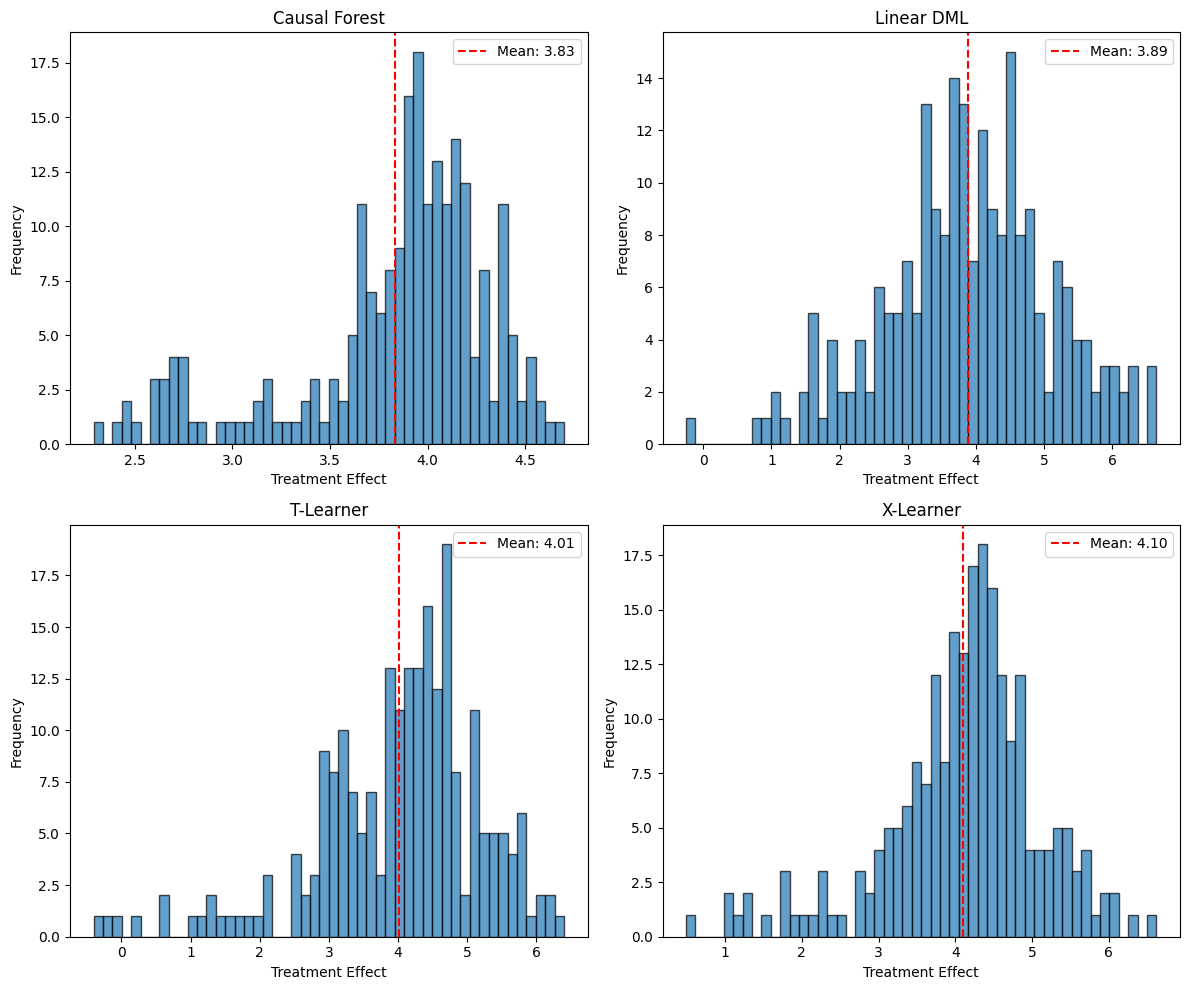

In [32]:
if __name__ == "__main__":
    main()

# Dataset Exploration


In [37]:
print("=" * 80)
print("LOADING IHDP DATASET")
print("=" * 80)

data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data = data.astype({"treatment":'bool'}, copy=False)
data.head()

LOADING IHDP DATASET


,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


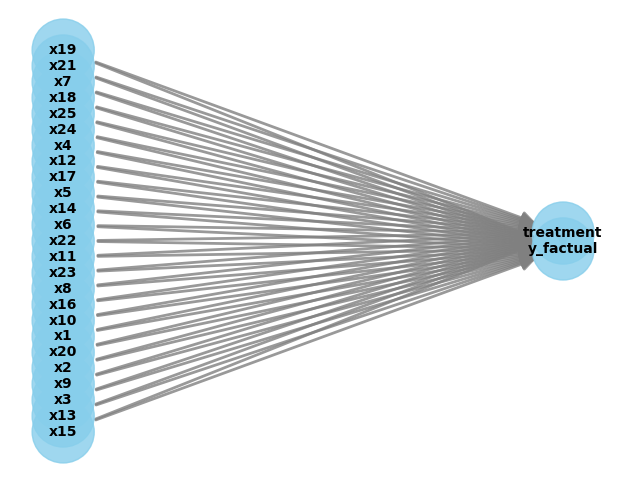

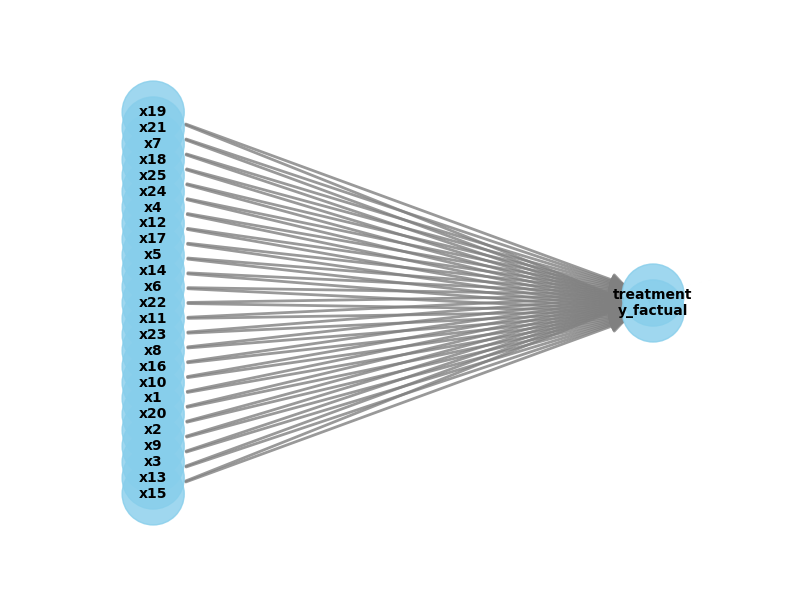

In [ ]:
# Create a more comprehensive causal model with enhanced graph specification
import networkx as nx
from dowhy import CausalModel

# Define confounders with meaningful groupings
# Based on IHDP dataset structure, these typically represent:
# - Maternal characteristics (x1-x10)
# - Child characteristics (x11-x20)
# - Environmental factors (x21-x25)

confounders = ["x"+str(i) for i in range(1,26)]

# Create the causal model with explicit graph specification
model = CausalModel(
    data=data,
    treatment='treatment',
    outcome='y_factual',
    common_causes=confounders,
    # Add instruments if available (uncomment if you have valid instruments)
    # instruments=['instrument_var'],
    # Add effect modifiers for heterogeneous effects
    effect_modifiers=confounders[:10]  # Use first 10 covariates as potential effect modifiers
)

# View the basic causal graph
print("Generating causal graph...")
model.view_model()

# Display the generated graph
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Print model summary
print("\n" + "="*80)
print("CAUSAL MODEL SUMMARY")
print("="*80)
print(f"Treatment variable: {model._treatment[0]}")
print(f"Outcome variable: {model._outcome[0]}")
print(f"Number of common causes (confounders): {len(confounders)}")
print(f"Number of effect modifiers: {len(confounders[:10])}")
print(f"Sample size: {len(data)}")

# Display the identified causal estimand
print("\n" + "="*80)
print("CAUSAL IDENTIFICATION")
print("="*80)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


In [ ]:
# Create a more detailed custom causal graph visualization
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch

def create_detailed_causal_graph(data, confounders, save_path='detailed_causal_graph.png'):
    """
    Create a comprehensive causal graph with grouped confounders and detailed structure.
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Group confounders into meaningful categories
    maternal_chars = [f"x{i}" for i in range(1, 11)]  # x1-x10
    child_chars = [f"x{i}" for i in range(11, 21)]    # x11-x20
    env_factors = [f"x{i}" for i in range(21, 26)]    # x21-x25
    
    # Add nodes
    G.add_node("Treatment", node_type='treatment')
    G.add_node("Outcome\n(y_factual)", node_type='outcome')
    
    # Add edges from confounders to treatment and outcome
    for conf in confounders:
        G.add_node(conf, node_type='confounder')
        G.add_edge(conf, "Treatment")
        G.add_edge(conf, "Outcome\n(y_factual)")
    
    # Add treatment effect
    G.add_edge("Treatment", "Outcome\n(y_factual)", edge_type='causal')
    
    # Define positions for better layout
    pos = {}
    
    # Treatment and Outcome positions
    pos["Treatment"] = (0.3, 0.5)
    pos["Outcome\n(y_factual)"] = (0.7, 0.5)
    
    # Position confounders in three groups
    y_start = 0.85
    y_spacing = 0.06
    
    # Maternal characteristics (left top)
    for i, conf in enumerate(maternal_chars):
        pos[conf] = (0.1, y_start - i * y_spacing)
    
    # Child characteristics (middle top)
    for i, conf in enumerate(child_chars):
        pos[conf] = (0.5, y_start - i * y_spacing)
    
    # Environmental factors (right top)
    for i, conf in enumerate(env_factors):
        pos[conf] = (0.9, y_start - i * y_spacing)
    
    # Draw the graph
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.0)
    ax.axis('off')
    
    # Draw group boxes
    # Maternal box
    maternal_box = FancyBboxPatch((0.02, 0.15), 0.15, 0.75, 
                                   boxstyle="round,pad=0.01", 
                                   edgecolor='steelblue', 
                                   facecolor='lightblue', 
                                   alpha=0.2, 
                                   linewidth=2)
    ax.add_patch(maternal_box)
    ax.text(0.095, 0.92, 'Maternal\nCharacteristics', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # Child box
    child_box = FancyBboxPatch((0.42, 0.15), 0.15, 0.75, 
                               boxstyle="round,pad=0.01", 
                               edgecolor='darkgreen', 
                               facecolor='lightgreen', 
                               alpha=0.2, 
                               linewidth=2)
    ax.add_patch(child_box)
    ax.text(0.495, 0.92, 'Child\nCharacteristics', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # Environmental box
    env_box = FancyBboxPatch((0.82, 0.15), 0.15, 0.75, 
                            boxstyle="round,pad=0.01", 
                            edgecolor='darkorange', 
                            facecolor='wheat', 
                            alpha=0.2, 
                            linewidth=2)
    ax.add_patch(env_box)
    ax.text(0.895, 0.92, 'Environmental\nFactors', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Draw edges from confounders (lighter color)
    for conf in confounders:
        # To treatment
        ax.annotate('', xy=pos["Treatment"], xytext=pos[conf],
                   arrowprops=dict(arrowstyle='->', lw=0.5, alpha=0.3, color='gray'))
        # To outcome
        ax.annotate('', xy=pos["Outcome\n(y_factual)"], xytext=pos[conf],
                   arrowprops=dict(arrowstyle='->', lw=0.5, alpha=0.3, color='gray'))
    
    # Draw main causal edge (treatment -> outcome) - bold
    ax.annotate('', xy=pos["Outcome\n(y_factual)"], xytext=pos["Treatment"],
               arrowprops=dict(arrowstyle='->', lw=3, alpha=0.9, color='red'))
    ax.text(0.5, 0.53, 'Causal Effect', ha='center', va='bottom', 
            fontsize=11, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Draw confounders as small circles
    for conf in confounders:
        circle = plt.Circle(pos[conf], 0.015, color='gray', alpha=0.6, zorder=3)
        ax.add_patch(circle)
        ax.text(pos[conf][0], pos[conf][1], conf, 
               ha='center', va='center', fontsize=7, zorder=4)
    
    # Draw treatment node
    treatment_circle = plt.Circle(pos["Treatment"], 0.05, 
                                  color='blue', alpha=0.7, zorder=3)
    ax.add_patch(treatment_circle)
    ax.text(pos["Treatment"][0], pos["Treatment"][1], "Treatment", 
           ha='center', va='center', fontsize=12, fontweight='bold', 
           color='white', zorder=4)
    
    # Draw outcome node
    outcome_circle = plt.Circle(pos["Outcome\n(y_factual)"], 0.05, 
                               color='green', alpha=0.7, zorder=3)
    ax.add_patch(outcome_circle)
    ax.text(pos["Outcome\n(y_factual)"][0], pos["Outcome\n(y_factual)"][1], 
           "Outcome\n(y_factual)", ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white', zorder=4)
    
    # Add title
    plt.title('Comprehensive Causal Graph: IHDP Dataset\n' + 
              'Treatment Effect on Child Health Outcomes with Confounders',
              fontsize=14, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='red', lw=3, label='Causal Effect (Treatment → Outcome)'),
        plt.Line2D([0], [0], color='gray', lw=1, alpha=0.5, label='Confounding Paths'),
        plt.Circle((0, 0), 0.05, color='blue', alpha=0.7, label='Treatment Variable'),
        plt.Circle((0, 0), 0.05, color='green', alpha=0.7, label='Outcome Variable'),
        plt.Circle((0, 0), 0.02, color='gray', alpha=0.6, label='Confounders (x1-x25)')
    ]
    ax.legend(handles=legend_elements, loc='lower center', 
             bbox_to_anchor=(0.5, -0.08), ncol=3, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nDetailed causal graph saved as '{save_path}'")
    
    return fig

# Generate the detailed graph
fig = create_detailed_causal_graph(data, confounders)
plt.show()

# Display statistics about the causal structure
print("\n" + "="*80)
print("CAUSAL STRUCTURE ANALYSIS")
print("="*80)
print(f"\nConfounder Groups:")
print(f"  Maternal Characteristics (x1-x10):  10 variables")
print(f"  Child Characteristics (x11-x20):    10 variables")
print(f"  Environmental Factors (x21-x25):     5 variables")
print(f"  Total Confounders:                   25 variables")
print(f"\nCausal Paths:")
print(f"  Direct: Treatment → Outcome")
print(f"  Confounding: {25 * 2} backdoor paths (25 confounders × 2 edges each)")
print(f"\nIdentification Strategy:")
print(f"  Control for all 25 confounders to block backdoor paths")
print(f"  Estimate causal effect using backdoor adjustment")


In [ ]:
# Analyze correlations and relationships in the causal structure
print("\n" + "="*80)
print("CORRELATION ANALYSIS: Understanding Relationships")
print("="*80)

# Calculate correlations between confounders and treatment
print("\nTop 10 Confounders Most Correlated with Treatment:")
treatment_corrs = []
for conf in confounders:
    corr = data[conf].corr(data['treatment'].astype(int))
    treatment_corrs.append((conf, corr))

treatment_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"{'Confounder':<12} {'Correlation':>12}")
print("-" * 30)
for conf, corr in treatment_corrs[:10]:
    print(f"{conf:<12} {corr:>12.4f}")

# Calculate correlations between confounders and outcome
print("\nTop 10 Confounders Most Correlated with Outcome:")
outcome_corrs = []
for conf in confounders:
    corr = data[conf].corr(data['y_factual'])
    outcome_corrs.append((conf, corr))

outcome_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"{'Confounder':<12} {'Correlation':>12}")
print("-" * 30)
for conf, corr in outcome_corrs[:10]:
    print(f"{conf:<12} {corr:>12.4f}")

# Create correlation heatmap for top confounders
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get top 10 confounders by treatment correlation
top_treatment_conf = [c[0] for c in treatment_corrs[:10]]
# Get top 10 confounders by outcome correlation
top_outcome_conf = [c[0] for c in outcome_corrs[:10]]

# Heatmap 1: Treatment-related confounders
data_subset1 = data[top_treatment_conf + ['treatment', 'y_factual']].copy()
data_subset1['treatment'] = data_subset1['treatment'].astype(int)
corr_matrix1 = data_subset1.corr()

sns.heatmap(corr_matrix1, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Correlation Matrix: Top Treatment-Associated Confounders', 
                  fontsize=12, fontweight='bold')

# Heatmap 2: Outcome-related confounders
data_subset2 = data[top_outcome_conf + ['treatment', 'y_factual']].copy()
data_subset2['treatment'] = data_subset2['treatment'].astype(int)
corr_matrix2 = data_subset2.corr()

sns.heatmap(corr_matrix2, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Correlation Matrix: Top Outcome-Associated Confounders', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confounder_correlations.png', dpi=300, bbox_inches='tight')
print("\nCorrelation heatmaps saved as 'confounder_correlations.png'")
plt.show()

# Identify potential strong confounders (high correlation with both)
print("\n" + "="*80)
print("STRONG CONFOUNDERS (High correlation with both Treatment and Outcome)")
print("="*80)

strong_confounders = []
for conf in confounders:
    t_corr = abs(data[conf].corr(data['treatment'].astype(int)))
    o_corr = abs(data[conf].corr(data['y_factual']))
    
    # Consider strong if both correlations > 0.1
    if t_corr > 0.1 and o_corr > 0.1:
        strong_confounders.append((conf, t_corr, o_corr, t_corr * o_corr))

strong_confounders.sort(key=lambda x: x[3], reverse=True)

if strong_confounders:
    print(f"\n{'Confounder':<12} {'|Corr(T)|':>12} {'|Corr(Y)|':>12} {'Product':>12}")
    print("-" * 52)
    for conf, t_corr, o_corr, prod in strong_confounders:
        print(f"{conf:<12} {t_corr:>12.4f} {o_corr:>12.4f} {prod:>12.4f}")
    print(f"\nIdentified {len(strong_confounders)} strong confounders that require careful adjustment")
else:
    print("\nNo variables meet the threshold for strong confounding (|corr| > 0.1 with both)")

print("\n" + "="*80)
print("CAUSAL ASSUMPTIONS")
print("="*80)
print("""
Key Assumptions for Causal Identification:

1. **Unconfoundedness (Ignorability)**: 
   - All confounders are observed and included in the model
   - No unmeasured confounding between treatment and outcome

2. **Positivity (Overlap)**:
   - For each covariate pattern, there is a positive probability of 
     receiving both treatment and control

3. **Consistency (SUTVA)**:
   - The potential outcome for each unit is unaffected by treatment 
     assignment of other units
   - Well-defined treatment (no different versions of treatment)

4. **Correct Model Specification**:
   - The functional form relating confounders to treatment and outcome
     is correctly specified

These assumptions enable identification of the causal effect via backdoor adjustment.
""")
